In [1]:
import sys
sys.path.append('/home/remi/Programmes/robust-line-based-estimator/third_party')
import cv2
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch

from robust_line_based_estimator.datasets.amsterdam_house import AmsterdamHouse
from robust_line_based_estimator.line_matching.line_matcher import LineMatcher
from robust_line_based_estimator.vp_matcher import vp_matching
from robust_line_based_estimator.line_junction_utils import get_line_junctions
from robust_line_based_estimator.evaluation import evaluate_R_t, pose_auc
from robust_line_based_estimator.visualization import (plot_images, plot_lines, plot_color_line_matches,
                                                       plot_vp, plot_keypoints, plot_matches)
from SuperGluePretrainedNetwork.models.matching import Matching
import pygcransac
import pyprogressivex

In [2]:
def verify_pyprogressivex(img, lines_segments, threshold = 2.0):     

    lines = []
    weights = []
    for i in range(lines_segments.shape[0]):
        p0 = lines_segments[i,0]
        p1 = lines_segments[i,1]
        len = np.linalg.norm(p1 - p0)
        lines.append([p0[0], p0[1], p1[0], p1[1]])
        weights.append(len)

    lines = np.array(lines)
    weights = np.array(weights)    

    vanishing_points, labeling = pyprogressivex.findVanishingPoints(
        np.ascontiguousarray(lines), 
        np.ascontiguousarray(weights), 
        img.shape[1], img.shape[0], 
        threshold = threshold,
        conf = 0.99,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 1.0,
        maximum_tanimoto_similarity = 1.0,
        max_iters = 1000,
        minimum_point_number = 5,
        maximum_model_number = -1,
        sampler_id = 0,
        scoring_exponent = 1.0,
        do_logging = False)    
    return vanishing_points, labeling


def find_homography_points(lines0, lines1, img1_size, img2_size, threshold = 3.0,
                           confidence = 0.5, minimum_point_number = 10):
    if lines0.shape[0] != lines1.shape[0]:
        print("The number of line segments do not match.")
        return

    line_number = lines0.shape[0]
    correspondences = []

    for i in range(line_number):
        correspondences.append([lines0[i][0][0], lines0[i][0][1], lines1[i][0][0], lines1[i][0][1]])
        correspondences.append([lines0[i][1][0], lines0[i][1][1], lines1[i][1][0], lines1[i][1][1]])
    correspondences = np.array(correspondences).astype(np.float64)
    
    homographies, labeling = pyprogressivex.findHomographies(
        np.ascontiguousarray(correspondences), 
        img1_size[1], img1_size[0], 
        img2_size[1], img2_size[0],
        threshold = threshold,
        conf = confidence,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 200.0,
        maximum_tanimoto_similarity = 0.4,
        max_iters = 1000,
        minimum_point_number = minimum_point_number,
        maximum_model_number = 10,
        sampler_id = 3,
        do_logging = False)

    model_number = max(labeling)    
    line_labeling = []
    for i in range(line_number):
        idx = 2 * i

        if labeling[idx] == labeling[idx + 1]: 
            line_labeling.append(labeling[idx])
        else:
            line_labeling.append(model_number)

    line_labeling = np.array(line_labeling)
    #for label in range(model_number):
    #    inliers = [index for index, element in enumerate(line_labeling) if element == label]
    #    print(len(inliers))
    #    if len(inliers) < minimum_point_number:
    #        line_labeling[inliers] = model_number

    return homographies, line_labeling


def normalize_keypoints(keypoints, K):
    '''Normalize keypoints using the calibration data.'''
    C_x = K[0, 2]
    C_y = K[1, 2]
    f_x = K[0, 0]
    f_y = K[1, 1]
    keypoints = (keypoints - np.array([[C_x, C_y]])) / np.array([[f_x, f_y]])
    return keypoints


def find_relative_pose_from_points(kp_matches, K1, K2, kp_scores=None):
    if kp_scores is not None:
        # Select the points with lowest ratio score
        good_matches = kp_scores < 0.8
        pts1 = kp_matches[good_matches, :2]
        pts2 = kp_matches[good_matches, 2:]
    else:
        pts1 = kp_matches[:, :2]
        pts2 = kp_matches[:, 2:]
        
    if len(pts1) < 5:
        return None, None, None, None
    
    # Normalize KP
    p1n = normalize_keypoints(pts1, K1)
    p2n = normalize_keypoints(pts2, K2)
    
    # Find the essential matrix with OpenCV RANSAC
    E, inl_mask = cv2.findEssentialMat(p1n, p2n, np.eye(3), cv2.RANSAC, 0.999, 1e-3)
    if E is None:
        return None, None, None, None
#     inl_mask = np.array(inl_mask)[:, 0].astype(bool)
#     pts1_inl = pts1[inl_mask]
#     pts2_inl = pts2[inl_mask]
    
    # Obtain the corresponding pose
    best_num_inliers = 0
    ret = None
    mask = np.array(inl_mask)[:, 0].astype(bool)
    for _E in np.split(E, len(E) / 3):
        n, R, t, _ = cv2.recoverPose(
            _E, p1n, p2n, np.eye(3), 1e9, mask=inl_mask[:, 0])
        if n > best_num_inliers:
            best_num_inliers = n
            ret = (R, t[:, 0], pts1[mask], pts2[mask])
    return ret
#     if E.size > 0:
#         _, R, t, _ = cv2.recoverPose(E, p1n, p2n)
#     else:
#         raise ValueError("Unable to recover a pose.")
    
#     return R, t, pts1_inl, pts2_inl

In [3]:
def Rt2E(R, t):
    t_skew = np.array([[0, -t[2], t[1]],
                       [t[2], 0, -t[0]],
                       [-t[1], t[0], 0]])
    return R @ t_skew

def get_inliers(pts1, pts2, R, t, K1, K2, thresh=1e-3):
    E = Rt2E(R, t)

    # Normalize KP
    p1n = np.concatenate([normalize_keypoints(pts1, K1), np.ones_like(pts1[:, :1])], axis=1)
    p2n = np.concatenate([normalize_keypoints(pts2, K2), np.ones_like(pts2[:, :1])], axis=1)

    # Compute epipolar error and inliers
    p2En = (E @ p2n.T).T
    error = np.sum(p1n * p2En, axis=1)
#     print(error)
    inliers = error < thresh
    return inliers

## Relative pose estimation on Amsterdam House

In [4]:
# Initialize the dataset
dataset = AmsterdamHouse(root_dir="/home/remi/Documents/datasets/amsterdam-house-full", split='test')
dataloader = dataset.get_dataloader()

# Initialize the line method
conf = {
    'sold2': {
        'ckpt_path': '../third_party/SOLD2/pretrained_models/sold2_wireframe.tar',
        'device': 'cpu'
    },
    'sg_params': {'weights': 'indoor'},
}
line_method = 'lsd'  # 'lsd' or 'SOLD2' supported for now
matcher = 'superglue_endpoints'  # 'lbd', 'sold2' or 'superglue_endpoints'
line_matcher = LineMatcher(line_detector=line_method, line_matcher=matcher, conf=conf)

Initialized Amsterdam House dataset with 49 image pairs.
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


In [5]:
# Initialize SuperPoint + SuperGlue (only used as a point baseline)
config = {
    'superpoint': {
        'nms_radius': 4,
        'max_keypoints': 1024,
    },
    'superglue': {'weights': 'indoor'}
}
device = 'cuda'
superglue_matcher = Matching(config).eval().to(device)

def sg_matching(img1, img2, superglue_matcher, device):
    with torch.no_grad():
        inputs = {
            'image0': torch.tensor(img1, dtype=torch.float, device=device)[None, None] / 255.,
            'image1': torch.tensor(img2, dtype=torch.float, device=device)[None, None] / 255.
        }
        pred = superglue_matcher(inputs)
        pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
        kpts0, kpts1 = pred['keypoints0'], pred['keypoints1']
        matches, conf = pred['matches0'], pred['matching_scores0']
     # Keep the matching keypoints.
    valid = matches > -1
    mkpts0 = kpts0[valid]
    mkpts1 = kpts1[matches[valid]]
    mconf = conf[valid]
    return np.concatenate([mkpts0, mkpts1], axis=1), mconf

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


/home/remi/env_daniel/lib/python3.6/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/home/remi/Programmes/robust-line-based-estimator/robust_line_based_estimator/line_matching/superglue_endpoints.py:549: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float, device=self.device),
/home/remi/Programmes/robust-line-based-estimator/robust_line_based_estimator/line_matching/superglue_endpoints.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rat

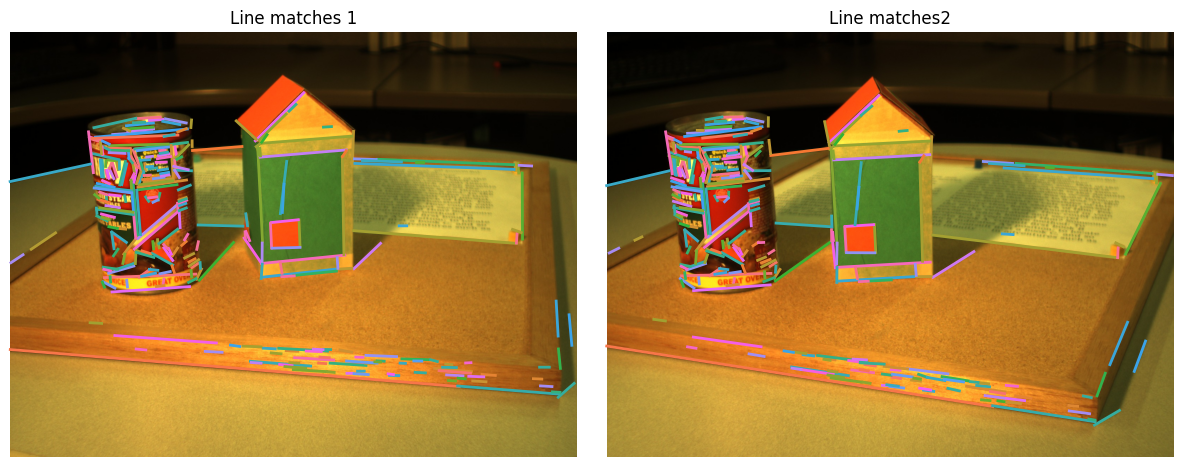

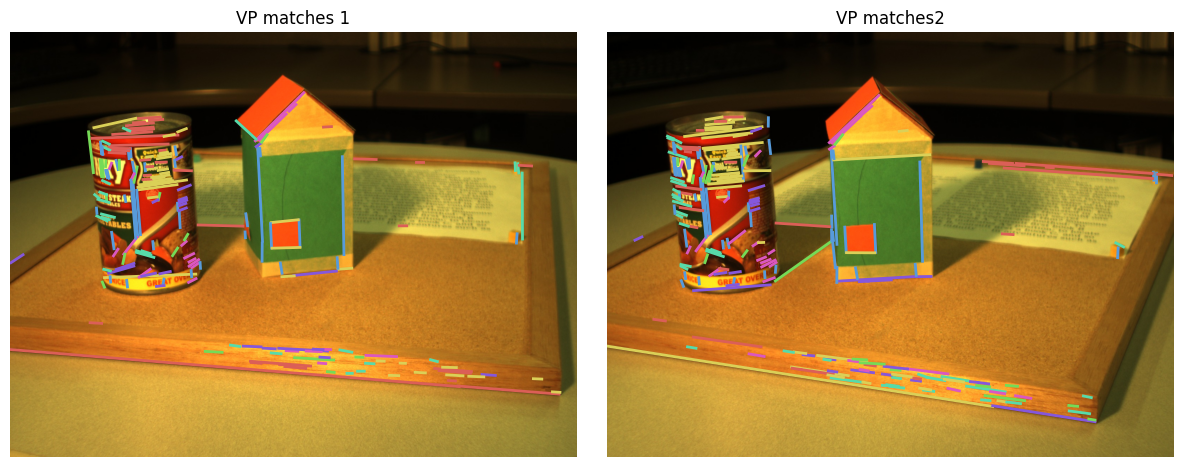

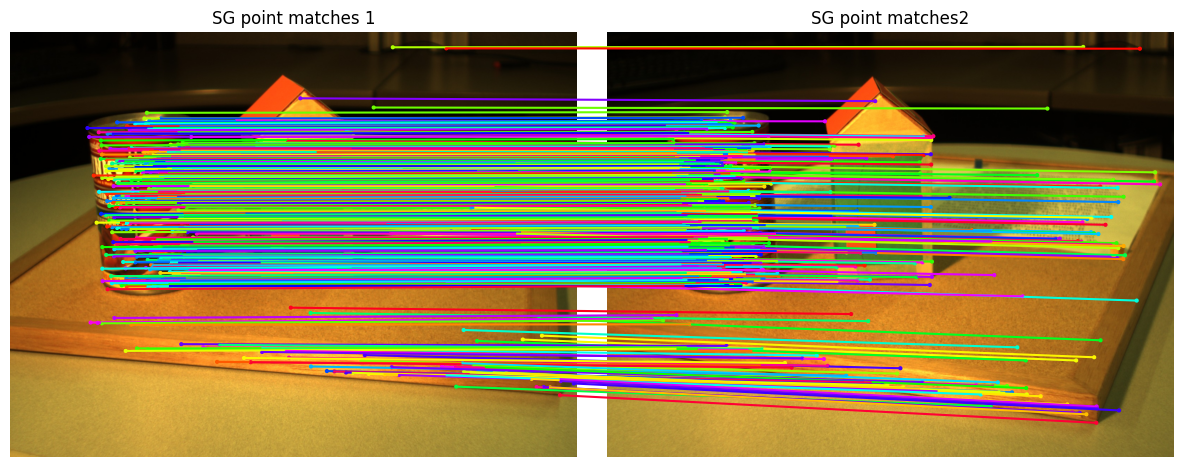

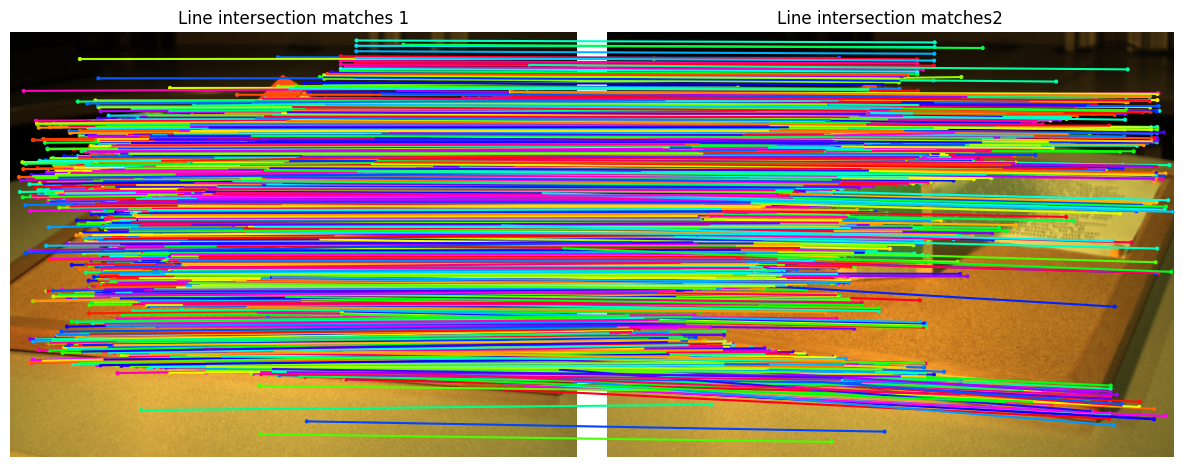

In [6]:
# Check that the evaluation tool works with a few visualizations
num_images = 1
for i, data in enumerate(dataloader):
    if i >= num_images:
        break

    img1 = data["img1"]
    h1, w1 = img1.shape[:2]
    img2 = data["img2"]
    h2, w2 = img2.shape[:2]
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    gt_R_1_2 = data["R_1_2"]
    gt_T_1_2 = data["T_1_2"]
    K1 = data["K1"]
    K2 = data["K2"]
    
    # Detect, describe and match lines
    line_feat1 = line_matcher.detect_and_describe_lines(gray_img1)
    line_feat2 = line_matcher.detect_and_describe_lines(gray_img2)
    _, m_lines1, m_lines2 = line_matcher.match_lines(gray_img1, gray_img2, line_feat1, line_feat2)
        
    # Compute and match VPs
    m_lines1_inl = m_lines1[:, :, [1, 0]]
    vp1, label1 = verify_pyprogressivex(gray_img1, m_lines1_inl, threshold=1.5)
    m_lines2_inl = m_lines2[:, :, [1, 0]]
    vp2, label2 = verify_pyprogressivex(gray_img2, m_lines2_inl, threshold=1.5)
    m_vp1, m_label1, m_vp2, m_label2 = vp_matching(vp1, label1, vp2, label2)
    
    # Compute homographies from lines
#     homographies, labels = find_homography_points(m_lines1[:, :, [1, 0]], m_lines2[:, :, [1, 0]],
#                                                   gray_img1.shape, gray_img2.shape)
#     n_homographies = max(labels)
#     colors = sns.color_palette('husl', n_colors=n_homographies + 1)

    # Compute point matches with SuperPoint + SuperGlue (as a sanity check)
    mkpts, _ = sg_matching(gray_img1, gray_img2, superglue_matcher, device)
    R, t, pts1_inl, pts2_inl = find_relative_pose_from_points(mkpts, K1, K2)
#     print("Pose error:", max(evaluate_R_t(gt_R_1_2, gt_T_1_2, R, -t)))
    
    # Match line intersections
    kp1, kp2, _ = get_line_junctions(m_lines1, m_lines2)
    valid1 = (kp1[:, 0] >= 0) & (kp1[:, 0] < h1) & (kp1[:, 1] >= 0) & (kp1[:, 1] < w1)
    valid2 = (kp2[:, 0] >= 0) & (kp2[:, 0] < h2) & (kp2[:, 1] >= 0) & (kp2[:, 1] < w2)
    valid = valid1 & valid2
    kp1 = kp1[valid]
    kp2 = kp2[valid]
    mlkpts = np.concatenate([kp1[:, [1, 0]], kp2[:, [1, 0]]], axis=1)
    _, _, lpts1_inl, lpts2_inl = find_relative_pose_from_points(mlkpts, K1, K2)

    # Display the matched lines, VPs, and homographies
    plot_images([img1, img2], ['Line matches 1', 'Line matches2'])
    plot_color_line_matches([m_lines1[:, :, [1, 0]], m_lines2[:, :, [1, 0]]])
    plot_images([img1, img2], ['VP matches 1', 'VP matches2'])
    plot_vp([m_lines1_inl, m_lines2_inl], [m_label1, m_label2])
    plot_images([img1, img2], ['SG point matches 1', 'SG point matches2'])
    plot_matches(pts1_inl, pts2_inl)
    plot_images([img1, img2], ['Line intersection matches 1', 'Line intersection matches2'])
#     plot_matches(kp1[:, [1, 0]], kp2[:, [1, 0]])
    plot_matches(lpts1_inl, lpts2_inl)